| **Title**      |Fuel Efficiency Prediction |
| ---------- |-------------------|
| **Team**       |Nguyễn Hữu Bảo Long - longnguyen3@glassegg.com <br/> Trương Hoàng Ngân - ngantruong@glassegg.com |
| **Predicting** |We will build a model to predict the fuel efficiency (MPG-Miles Per Gallon)|
| **Data**       |Auto MPG Data Set <br/> UCI Machine Learning Repository Data link : https://archive.ics.uci.edu/ml/datasets/auto+mpg |
| **Features**   | <ol> <li>mpg: continuous</li> <li>cylinders: multi-valued discrete</li> <li>displacement: continuous</li> <li>horsepower: continuous</li> <li>weight: continuous</li> <li>acceleration: continuous</li> <li>model year: multi-valued discrete</li> <li>origin: multi-valued discrete</li> </ol>|
| **Models**     |<ol> <li>Multi-layer Perceptron is a class of feedforward artificial neural network. <br/> An MLP consists of at least three layers of nodes: an input layer, a hidden layer and an output layer. <br/> MLP utilizes a supervised learning technique called backpropagation for training.</li>  <li>Regression Tree is a predictive model <br/> to go from observations about an item (represented in the branches) <br/> to conclusions about the item's target value (represented in the leaves).</li> <li>Regression Random Forests are an ensemble learning method <br/> for classification, regression and other tasks that operates <br/> by constructing a multitude of decision trees.</li> </ol>|
| **Discussion** |Which model return the better resuls? <br/> How to improve the other models? <br/> How to tuning the hyper parameters in models? |
| **Future**     |Applying the decision tree method into business problems (Predict Efficiency).<br/> Use other methods like: XGBoost, Reinforcement learning,...<br/> Use tuning methods like: gridsearchcv, pruning... |
|**References**  |[1] https://machinelearningcoban.com/2018/01/14/id3/ <br/> [2]https://towardsdatascience.com/random-forest-and-its-implementation-71824ced454f <br/> [3] https://www.youtube.com/watch?v=g9c66TUylZ4 <br/> [4] https://www.kaggle.com/arunkumarramanan/data-science-python-fuel-efficiency-prediction|
| **Results**    | |

In [308]:
from __future__ import absolute_import, division, print_function

import pathlib
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
# uninstall existing TensorFlow (TF-1.5) of Google Colab
!pip uninstall -y tensorflow
# install TensorFlow-2.0 with GPU support
!pip install tensorflow-gpu

In [309]:
import tensorflow as tf
from tensorflow import keras

dataset_path = keras.utils.get_file("auto-mpg.data", "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin'] 
# raw_dataset = pd.read_csv(dataset_path, names=column_names,
#                           comment='\t', sep=" ", skipinitialspace=True)
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.head(3)

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1


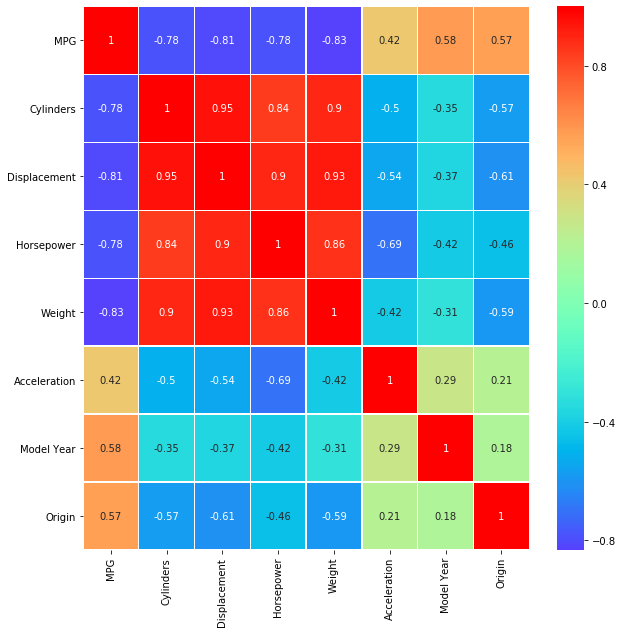

In [310]:
# dataset.describe()
# dataset.isnull().sum()
dataset.isna().sum()
dataset = dataset.dropna()
dataset.shape
dataset.corr()['MPG'].sort_values()
plt.figure(figsize=(10,10))
sns.heatmap(dataset.corr(), annot=True, linewidth=0.5, center=0, cmap='rainbow')
plt.show()

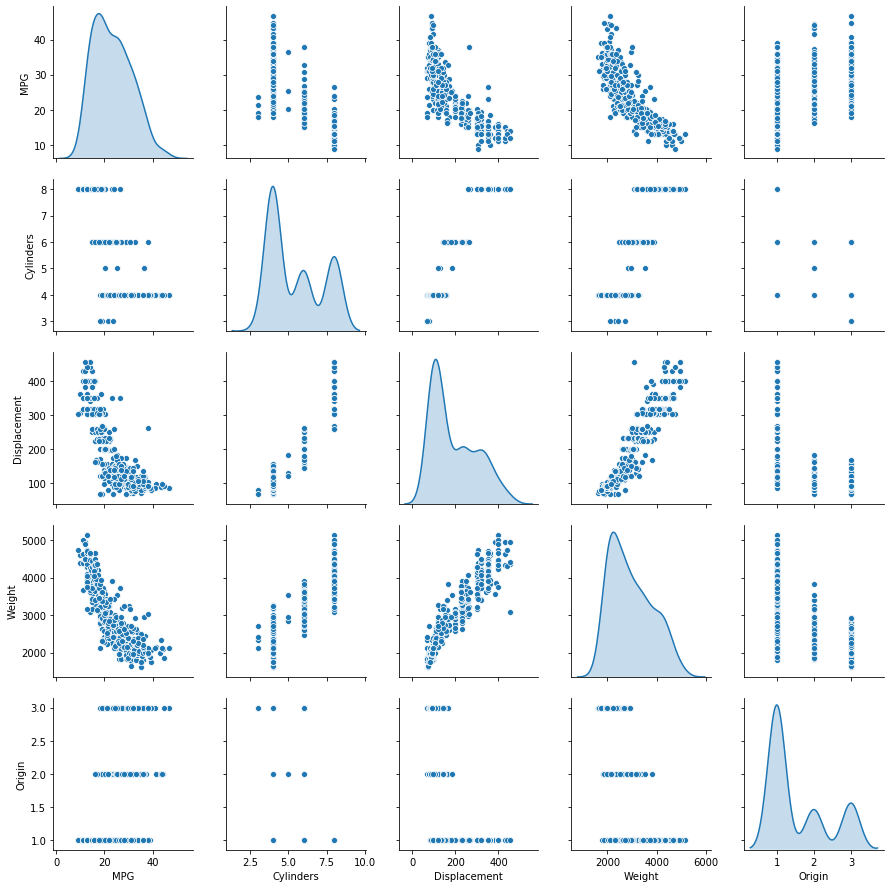

In [311]:
sns.pairplot(dataset[["MPG", "Cylinders", "Displacement", "Weight", "Origin"]], diag_kind="kde")

In [0]:
from tensorflow.keras import layers

train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

mlp_train_dataset = train_dataset.copy()
mlp_test_dataset = test_dataset.copy()

origin = mlp_train_dataset.pop('Origin')
mlp_train_dataset['USA'] = (origin == 1)*1.0
mlp_train_dataset['Europe'] = (origin == 2)*1.0
mlp_train_dataset['Japan'] = (origin == 3)*1.0

origin = mlp_test_dataset.pop('Origin')
mlp_test_dataset['USA'] = (origin == 1)*1.0
mlp_test_dataset['Europe'] = (origin == 2)*1.0
mlp_test_dataset['Japan'] = (origin == 3)*1.0


train_stats = mlp_train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()

train_stats

mlp_train_labels = mlp_train_dataset.pop('MPG')
mlp_test_labels = mlp_test_dataset.pop('MPG')

In [313]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']


normed_train_data = norm(mlp_train_dataset)
normed_test_data = norm(mlp_test_dataset)

train_stats_normalize = normed_train_data.describe()
train_stats_normalize = train_stats_normalize.transpose()
train_stats_normalize

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,2.093159e-16,1.0,-1.457657,-0.869348,-0.869348,1.483887,1.483887
Displacement,314.0,1.018294e-16,1.0,-1.220325,-0.860894,-0.424785,0.675074,2.489002
Horsepower,314.0,-1.909301e-17,1.0,-1.545283,-0.751241,-0.272190,0.607162,3.153347
Weight,314.0,-9.723291e-17,1.0,-1.589352,-0.869478,-0.198782,0.732017,2.547401
Acceleration,314.0,2.688832e-15,1.0,-2.710152,-0.630725,-0.021237,0.588250,3.313017
Model Year,314.0,9.561531e-16,1.0,-1.604642,-0.788458,0.027726,0.843910,1.660094
USA,314.0,6.081476e-17,1.0,-1.286751,-1.286751,0.774676,0.774676,0.774676
Europe,314.0,8.485781e-18,1.0,-0.465148,-0.465148,-0.465148,-0.465148,2.143005
Japan,314.0,3.164489e-17,1.0,-0.495225,-0.495225,-0.495225,-0.495225,2.012852


In [314]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(mlp_train_dataset.keys())]),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error', 'accuracy'])
  return model

model = build_model()
model.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_78 (Dense)             (None, 64)                640       
_________________________________________________________________
dense_79 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_80 (Dense)             (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [315]:
EPOCHS = 1000

history = model.fit(
  normed_train_data, mlp_train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,accuracy,val_loss,val_mean_absolute_error,val_mean_squared_error,val_accuracy,epoch
995,2.322029,0.916824,2.322029,0.0,8.918112,2.266948,8.918112,0.0,995
996,2.460421,0.991792,2.460421,0.0,8.603456,2.231784,8.603456,0.0,996
997,2.273850,0.922622,2.273850,0.0,8.419316,2.189940,8.419315,0.0,997
998,2.215750,0.933999,2.215750,0.0,8.731404,2.295226,8.731403,0.0,998
999,2.454354,0.991812,2.454354,0.0,8.685454,2.281753,8.685453,0.0,999


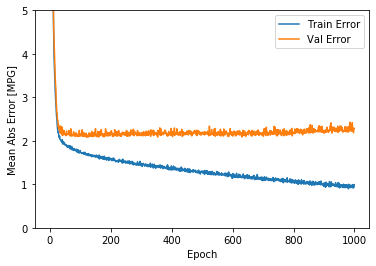

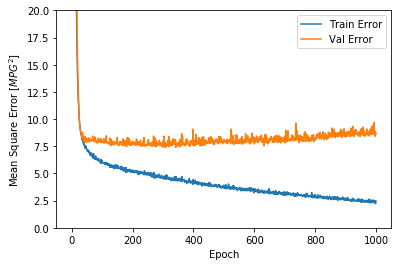

In [316]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

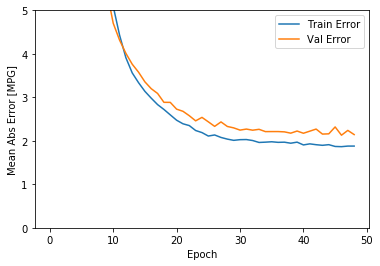

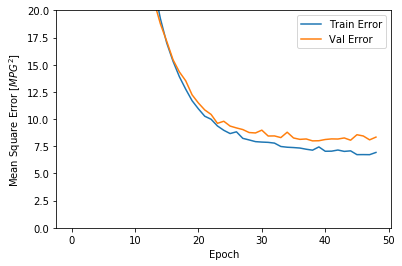

In [317]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, mlp_train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop])

plot_history(history)

In [318]:
loss, mae, mse, accuracy = model.evaluate(normed_test_data, mlp_test_labels)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

78/78 [==============================] - 0s 68us/sample - loss: 6.4602 - mean_absolute_error: 2.0427 - mean_squared_error: 6.4602 - accuracy: 0.0000e+00
Testing set Mean Abs Error:  2.04 MPG


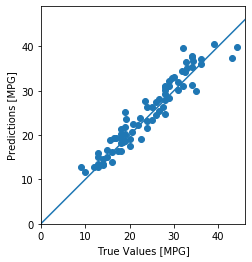

In [319]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(mlp_test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# train_dataset = dataset.sample(frac=0.9,random_state=0)
# test_dataset = dataset.drop(train_dataset.index)

DT_train_dataset = train_dataset.copy()
DT_test_dataset = test_dataset.copy()

y_train = DT_train_dataset.pop('MPG')
X_train = DT_train_dataset

y_valid = DT_test_dataset.pop('MPG')
X_valid = DT_test_dataset
# X_train, X_valid, y_train, y_valid = train_test_split(decision_tree_dataset, labels, random_state=0,test_size=0.2)

In [321]:
DT_train_stats = X_train.describe()
DT_train_stats = DT_train_stats.transpose()

DT_train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Origin,314.0,1.573248,0.800988,1.0,1.00,1.0,2.00,3.0


In [0]:
def norm(x):
  return (x - DT_train_stats['mean']) / DT_train_stats['std']

X_train = norm(X_train)
X_valid = norm(X_valid)

In [323]:
model_regressionTree = DecisionTreeRegressor(criterion='mse', max_depth=4,
                                             random_state=0)
model_regressionTree.fit(X_train, y_train)
print('Regression Tree score: ' + str(model_regressionTree.score(X_valid, y_valid)))

Regression Tree score: 0.8772300290913486


In [324]:
model_regressionRandomForest = RandomForestRegressor(criterion='mse', max_depth=4,
                                             random_state=0, n_estimators=300)
model_regressionRandomForest.fit(X_train, y_train)
print('Regression Tree score: ' + str(model_regressionRandomForest.score(X_valid, y_valid)))

Regression Tree score: 0.9084957992180025


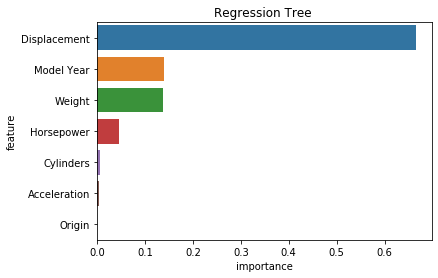

In [325]:
# feature importance
def drawFeatureImportance(model, title, n_top):
  importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(model.feature_importances_,3)})
  importances = importances.sort_values('importance',ascending=False).head(n_top)
  sns.barplot(y=importances['feature'],x=importances['importance']).set_title(title)

drawFeatureImportance(model_regressionTree, 'Regression Tree ',7)

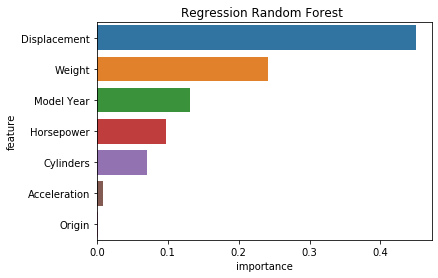

In [326]:
drawFeatureImportance(model_regressionRandomForest, 'Regression Random Forest ',7)

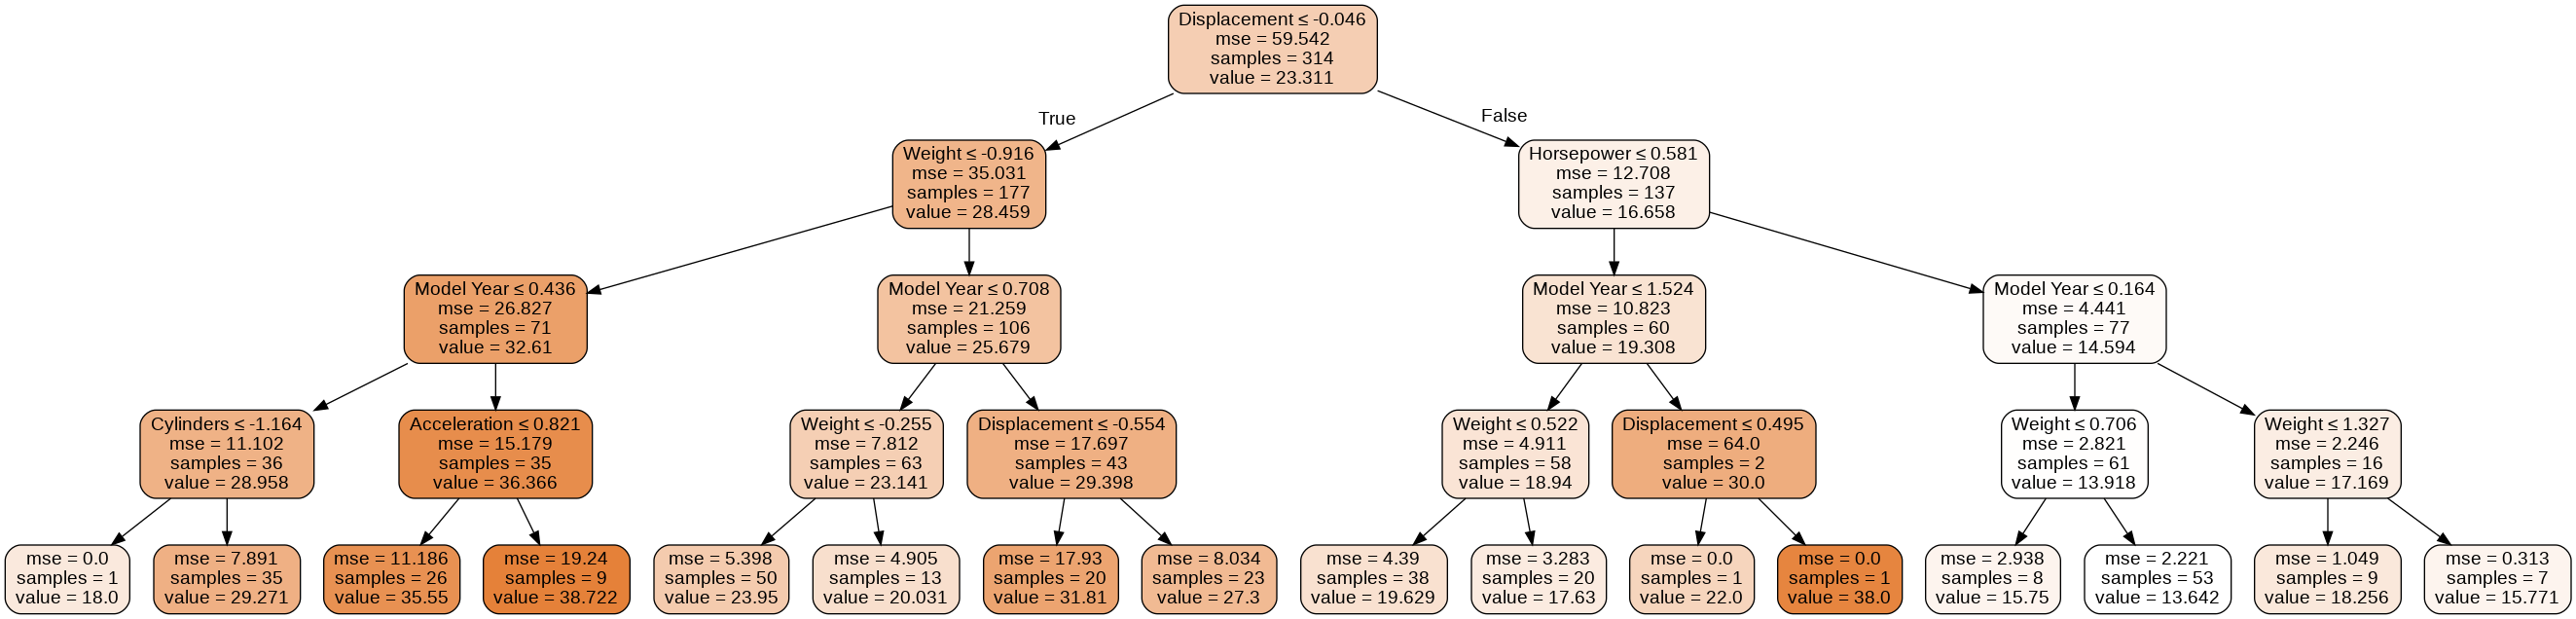

In [327]:
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image

# draw tree
def drawTree(model):
  dot_data = StringIO()
  export_graphviz(model, out_file=dot_data,  
                  filled=True, rounded=True,
                  special_characters=True,
                  feature_names = X_train.columns,
                  class_names=[str(x) for x in model.feature_importances_] #replace class_ by feature_importances_
                  )
  graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
  return graph.create_png()
Image(drawTree(model_regressionTree))

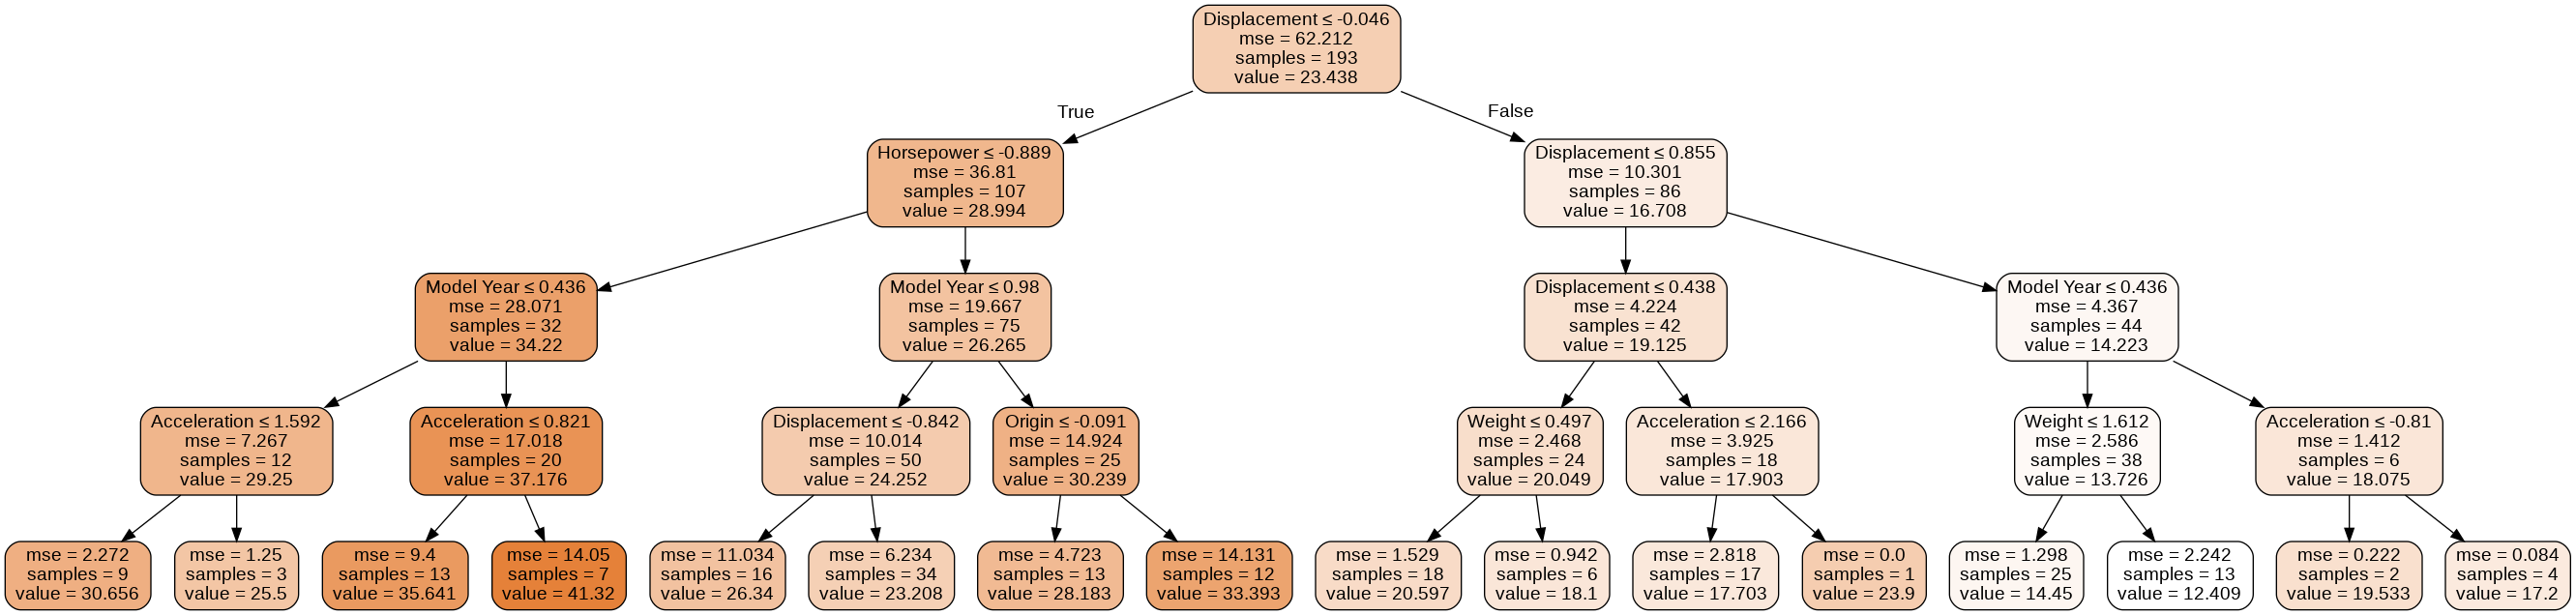

In [328]:
Image(drawTree(model_regressionRandomForest.estimators_[100]))

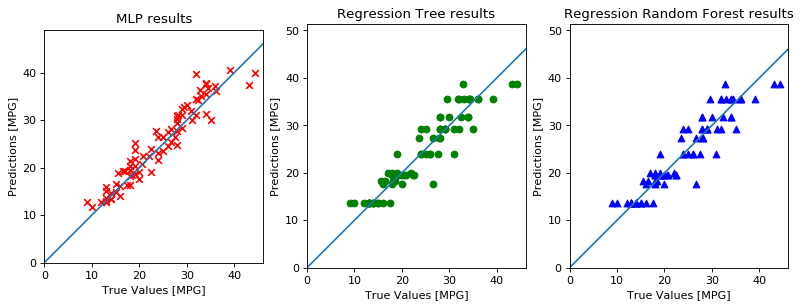

In [329]:
fig = plt.figure(figsize=(12, 6), dpi=80)

mlp_fig = fig.add_subplot(1, 3, 1)
plt.scatter(mlp_test_labels, test_predictions, marker='x', color='red')
mlp_fig.set_title('MLP results')
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

dt_fig = fig.add_subplot(1, 3, 2)
dt_fig.set_title('Regression Tree results')
regressionTree_predict = model_regressionTree.predict(X_valid).flatten()
plt.scatter(y_valid, regressionTree_predict, marker='o', color='green')
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

rf_fig = fig.add_subplot(1, 3, 3)
rf_fig.set_title('Regression Random Forest results')
regressionRandomForest_predict = model_regressionTree.predict(X_valid).flatten()
plt.scatter(y_valid, regressionRandomForest_predict, marker='^', color='blue')
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

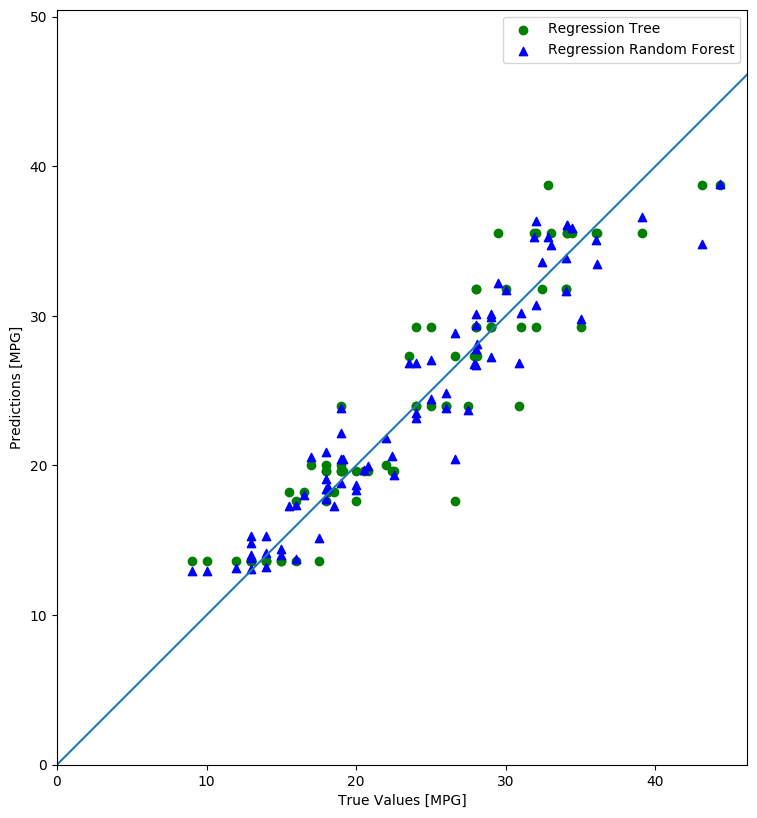

In [330]:
fig = plt.figure(figsize=(30, 10), dpi=100)

regressionTree_predict = model_regressionTree.predict(X_valid).flatten()
dt_fig = plt.scatter(y_valid, regressionTree_predict, marker='o', color='green')

regressionRandomForest_predict = model_regressionRandomForest.predict(X_valid).flatten()
rf_fig = plt.scatter(y_valid, regressionRandomForest_predict, marker='^', color='blue')

plt.legend((dt_fig, rf_fig), ('Regression Tree', 'Regression Random Forest'))

plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0, plt.xlim()[-1]])
plt.ylim([0, plt.ylim()[-1]])
_ = plt.plot([-100, 100], [-100, 100])

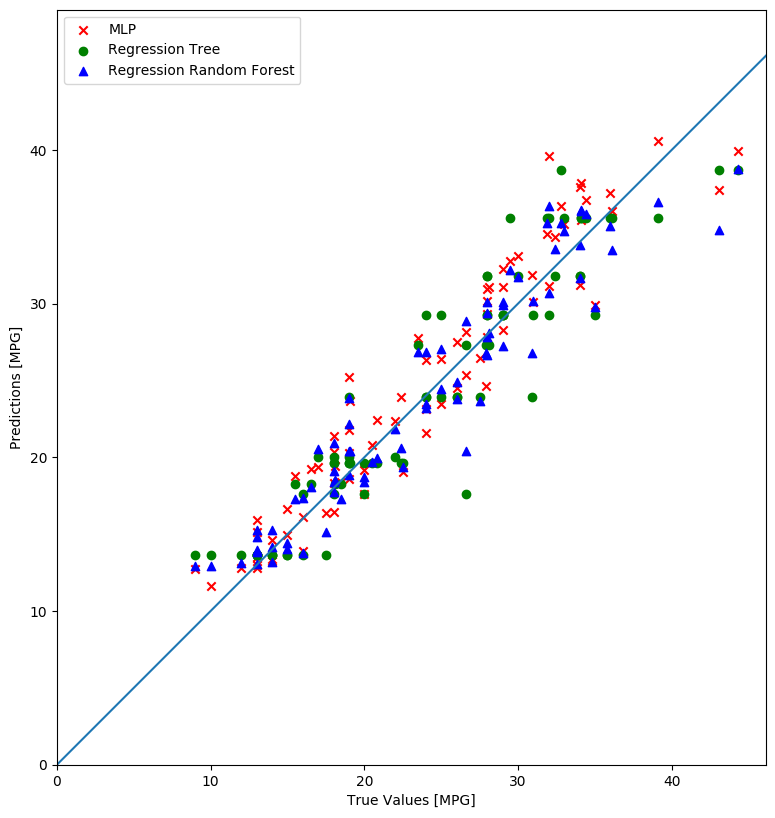

In [331]:
fig = plt.figure(figsize=(30, 10), dpi=100)
mlp_fig = plt.scatter(mlp_test_labels, test_predictions, marker='x', color='red')

regressionTree_predict = model_regressionTree.predict(X_valid).flatten()
dt_fig = plt.scatter(y_valid, regressionTree_predict, marker='o', color='green')

regressionRandomForest_predict = model_regressionRandomForest.predict(X_valid).flatten()
rf_fig = plt.scatter(y_valid, regressionRandomForest_predict, marker='^', color='blue')

plt.legend((mlp_fig, dt_fig, rf_fig), ('MLP', 'Regression Tree', 'Regression Random Forest'))

plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0, plt.xlim()[-1]])
plt.ylim([0, plt.ylim()[-1]])
_ = plt.plot([-100, 100], [-100, 100])